
# Real Estate Exploratory Data Analysis (EDA)

This notebook is tailored to your uploaded dataset: **`/../data/real_estate_data.csv`**.

**Objectives :**
- Data overview (shape, dtypes, duplicates, missingness)
- Type inference (numeric / datetime / categorical) with auto date parsing
- Missingness audit and bar chart of worst offenders
- Outlier diagnostics (IQR rule) + bar chart of most outlier-prone fields
- Distributions for high-variance numeric features (histograms)
- Correlation matrix + heatmap (matplotlib only)
- Target guessing (e.g., Price/Rent/Value) and quick baseline models
- Random Forest feature importances
- Monthly time trends (if a datetime column exists)
- Geo scatter (if latitude/longitude exist)
- Auto-generated insights and optional Stakeholder HTML report

> **Charts policy:** matplotlib only, one chart per figure, no explicit colors set.


In [1]:

# --- Setup & Imports ---
import os, io, base64, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)


In [2]:

# --- Load Data ---
# Adjust DATA_PATH if you move the file. For this environment, it's already here.
DATA_PATH = "../data/real_estate_data.csv"

# Read CSV with low_memory=False to reduce dtype fragmentation
df = pd.read_csv(DATA_PATH, low_memory=False)

df.head()


,tx_price,beds,baths,sqft,year_built,lot_size,property_type,exterior_walls,roof,basement,restaurants,groceries,nightlife,cafes,shopping,arts_entertainment,beauty_spas,active_life,median_age,married,college_grad,property_tax,insurance,median_school,num_schools,tx_year
0,295850,1,1,584,2013,0,Apartment / Condo / Townhouse,Wood Siding,NaN,NaN,107,9,30,19,89,6,47,58,33.0,65.0,84.0,234.0,81.0,9.0,3.0,2013
1,216500,1,1,612,1965,0,Apartment / Condo / Townhouse,Brick,Composition Shingle,1.0,105,15,6,13,87,2,26,14,39.0,73.0,69.0,169.0,51.0,3.0,3.0,2006
2,279900,1,1,615,1963,0,Apartment / Condo / Townhouse,Wood Siding,NaN,NaN,183,13,31,30,101,10,74,62,28.0,15.0,86.0,216.0,74.0,8.0,3.0,2012
3,379900,1,1,618,2000,33541,Apartment / Condo / Townhouse,Wood Siding,NaN,NaN,198,9,38,25,127,11,72,83,36.0,25.0,91.0,265.0,92.0,9.0,3.0,2005
4,340000,1,1,634,1992,0,Apartment / Condo / Townhouse,Brick,NaN,NaN,149,7,22,20,83,10,50,73,37.0,20.0,75.0,88.0,30.0,9.0,3.0,2002


In [ ]:
#df.columns = df.columns.str.strip()  # Remove leading/trailing whitespace from column names
#df.columns = df.columns.str.lower()  # Convert column names to lowercase
#df.columns = df.columns.str.replace(' ', '_')  # Replace spaces with underscores
#df.columns = df.columns.str.replace('-', '_')  # Replace hyphens with underscores
# display the cleaned column names
df.columns

Index(['tx_price', 'beds', 'baths', 'sqft', 'year_built', 'lot_size', 'property_type', 'exterior_walls', 'roof', 'basement', 'restaurants', 'groceries', 'nightlife', 'cafes', 'shopping',
       'arts_entertainment', 'beauty_spas', 'active_life', 'median_age', 'married', 'college_grad', 'property_tax', 'insurance', 'median_school', 'num_schools', 'tx_year'],
      dtype='object')

In [4]:
# check the data types of each column
df.dtypes

tx_price                int64
beds                    int64
baths                   int64
sqft                    int64
year_built              int64
lot_size                int64
property_type          object
exterior_walls         object
roof                   object
basement              float64
restaurants             int64
groceries               int64
nightlife               int64
cafes                   int64
shopping                int64
arts_entertainment      int64
beauty_spas             int64
active_life             int64
median_age            float64
married               float64
college_grad          float64
property_tax          float64
insurance             float64
median_school         float64
num_schools           float64
tx_year                 int64
dtype: object

In [5]:
# --- Convert year-only columns (year_built, tx_year, transaction_year) to datetime ---
year_only_cols = [c for c in ["year_built", "tx_year", "transaction_year"] if c in df.columns]

for col in year_only_cols:
    try:
        df[col] = pd.to_datetime(df[col].astype(str), format="%Y", errors="coerce")
        print(f"Converted '{col}' to datetime (YYYY -> YYYY-01-01).")
    except Exception as e:
        print(f"Could not convert '{col}':", e)

# Check result
if year_only_cols:
    print(df[year_only_cols].dtypes)

Converted 'year_built' to datetime (YYYY -> YYYY-01-01).
Converted 'tx_year' to datetime (YYYY -> YYYY-01-01).
year_built    datetime64[ns]
tx_year       datetime64[ns]
dtype: object


In [6]:

# --- Basic Overview ---
n_rows, n_cols = df.shape
num_duplicates = df.duplicated().sum()

print(f"Rows: {n_rows:,}")
print(f"Columns: {n_cols}")
print(f"Duplicate Rows: {int(num_duplicates)}")

print("\nDtypes:")
print(df.dtypes)

print("\nNull counts (top 20):")
print(df.isna().sum().sort_values(ascending=False).head(20))


Rows: 1,883
Columns: 26
Duplicate Rows: 0

Dtypes:
tx_price                       int64
beds                           int64
baths                          int64
sqft                           int64
year_built            datetime64[ns]
lot_size                       int64
property_type                 object
exterior_walls                object
roof                          object
basement                     float64
restaurants                    int64
groceries                      int64
nightlife                      int64
cafes                          int64
shopping                       int64
arts_entertainment             int64
beauty_spas                    int64
active_life                    int64
median_age                   float64
married                      float64
college_grad                 float64
property_tax                 float64
insurance                    float64
median_school                float64
num_schools                  float64
tx_year               da

In [7]:

# --- Helpers: Date Parsing & Type Inference ---
def try_parse_dates(_df: pd.DataFrame) -> pd.DataFrame:
    out = _df.copy()
    for c in _df.columns:
        lc = str(c).lower()
        if ("date" in lc) or ("time" in lc):
            out[c] = pd.to_datetime(_df[c], errors="ignore", infer_datetime_format=True)
    return out

def is_categorical(series: pd.Series, cat_unique_thresh: int = 30) -> bool:
    if series.dtype == "O":
        return True
    unique_vals = series.nunique(dropna=True)
    return unique_vals <= min(cat_unique_thresh, max(2, int(0.05 * len(series))))

df = try_parse_dates(df)

numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
datetime_cols = [c for c in df.columns if pd.api.types.is_datetime64_any_dtype(df[c])]
categorical_cols = [c for c in df.columns if (c not in numeric_cols + datetime_cols) and is_categorical(df[c])]

inventory = pd.DataFrame({
    "Column": df.columns,
    "InferredType": ["numeric" if c in numeric_cols else "datetime" if c in datetime_cols else "categorical" if c in categorical_cols else str(df[c].dtype) for c in df.columns],
    "NonNullCount": [df[c].notna().sum() for c in df.columns],
    "NullCount": [df[c].isna().sum() for c in df.columns],
    "UniqueValues": [df[c].nunique(dropna=True) for c in df.columns]
}).sort_values(by=["InferredType","Column"])

inventory


,Column,InferredType,NonNullCount,NullCount,UniqueValues
7,exterior_walls,categorical,1660,223,16
6,property_type,categorical,1883,0,2
8,roof,categorical,1529,354,16
25,tx_year,datetime,1883,0,24
4,year_built,datetime,1883,0,94
17,active_life,numeric,1883,0,81
15,arts_entertainment,numeric,1883,0,31
9,basement,numeric,1657,226,1
2,baths,numeric,1883,0,6
16,beauty_spas,numeric,1883,0,116


,Column,Missing_%
0,roof,18.80
1,basement,12.00
2,exterior_walls,11.84
3,tx_price,0.00
4,beds,0.00
5,baths,0.00
6,lot_size,0.00
7,year_built,0.00
8,sqft,0.00
9,property_type,0.00


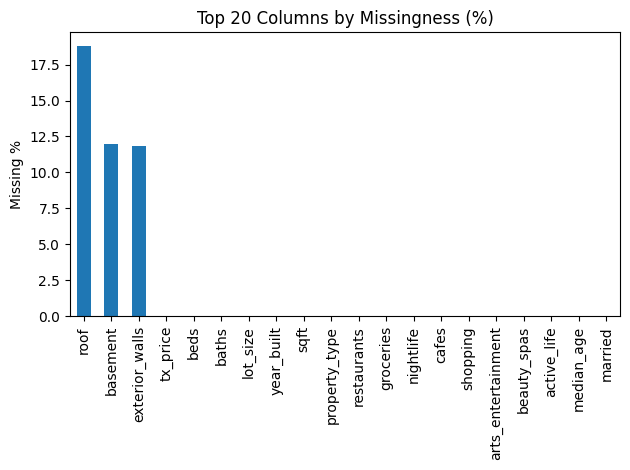

In [8]:

# --- Missingness Analysis ---
missing = (df.isna().mean() * 100).round(2).sort_values(ascending=False)
missing_df = missing.reset_index()
missing_df.columns = ["Column", "Missing_%"]
display(missing_df.head(30))

# Plot top 20 by missingness
top_missing = missing.head(20)
plt.figure()
top_missing.plot(kind="bar")
plt.title("Top 20 Columns by Missingness (%)")
plt.ylabel("Missing %")
plt.tight_layout()
plt.show()


In [9]:

# --- Numeric Summary ---
if numeric_cols:
    display(df[numeric_cols].describe().T)
else:
    print("No numeric columns detected.")


,count,mean,std,min,25%,50%,75%,max
tx_price,1883.0,422839.807754,151462.593276,200000.0,300000.0,392000.0,525000.0,800000.0
beds,1883.0,3.420605,1.068554,1.0,3.0,3.0,4.0,5.0
baths,1883.0,2.579926,0.945576,1.0,2.0,3.0,3.0,6.0
sqft,1883.0,2329.398832,1336.991858,500.0,1345.0,1907.0,3005.0,8450.0
lot_size,1883.0,13392.620287,44949.303601,0.0,1542.0,6098.0,11761.0,1220551.0
basement,1657.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
restaurants,1883.0,40.210303,46.867012,0.0,7.0,23.0,58.0,266.0
groceries,1883.0,4.505045,4.491029,0.0,1.0,3.0,7.0,24.0
nightlife,1883.0,5.074881,8.464668,0.0,0.0,2.0,6.0,54.0
cafes,1883.0,5.325013,7.539309,0.0,0.0,3.0,6.0,47.0


,Column,Outlier_%
9,cafes,9.88
8,nightlife,9.08
4,lot_size,7.65
10,shopping,7.01
6,restaurants,6.16
13,active_life,5.79
1,beds,4.78
11,arts_entertainment,4.57
18,insurance,4.04
17,property_tax,3.56


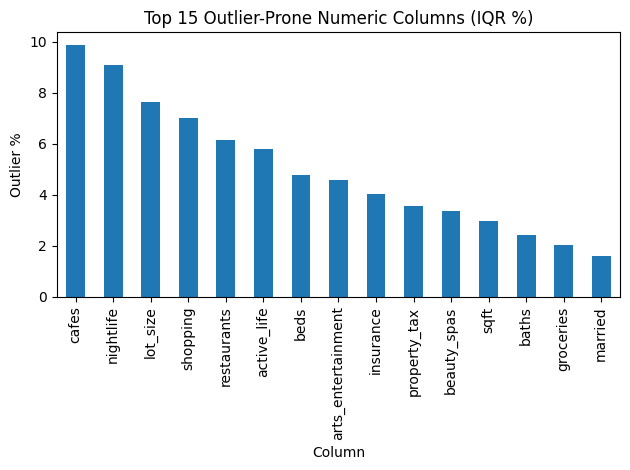

In [10]:

# --- Outlier Diagnostics (IQR rule) ---
def iqr_outlier_rate(series: pd.Series) -> float:
    s = series.dropna()
    if s.empty: return 0.0
    q1 = s.quantile(0.25); q3 = s.quantile(0.75); iqr = q3 - q1
    if iqr == 0: return 0.0
    lower = q1 - 1.5 * iqr; upper = q3 + 1.5 * iqr
    return float((((s < lower) | (s > upper)).mean() * 100).round(2))

outlier_rates = pd.DataFrame({
    "Column": numeric_cols,
    "Outlier_%": [iqr_outlier_rate(df[c]) for c in numeric_cols]
}).sort_values("Outlier_%", ascending=False)

display(outlier_rates.head(20))

plt.figure()
outlier_rates.head(15).set_index("Column")["Outlier_%"].plot(kind="bar")
plt.title("Top 15 Outlier-Prone Numeric Columns (IQR %)")
plt.ylabel("Outlier %")
plt.tight_layout()
plt.show()


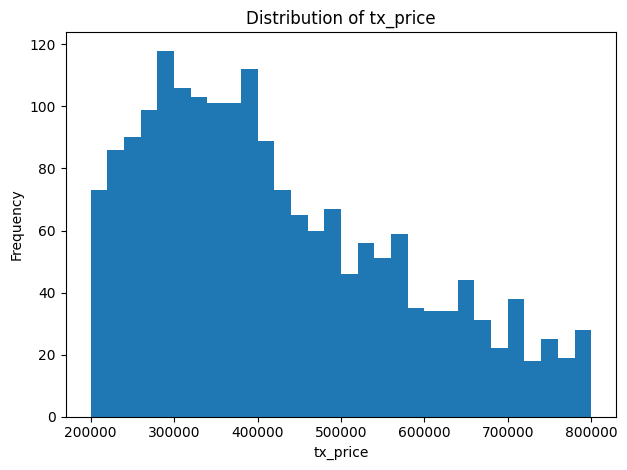

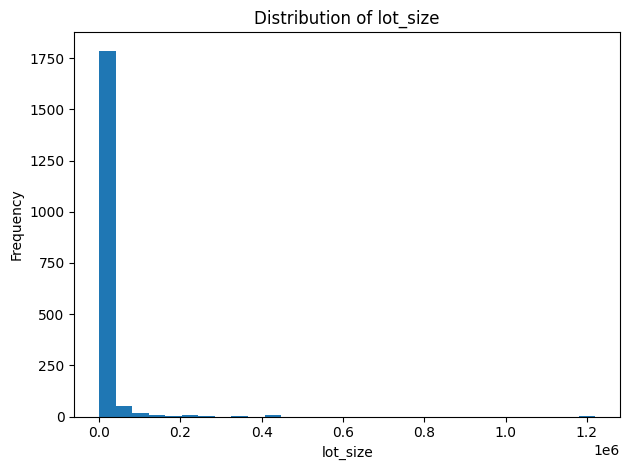

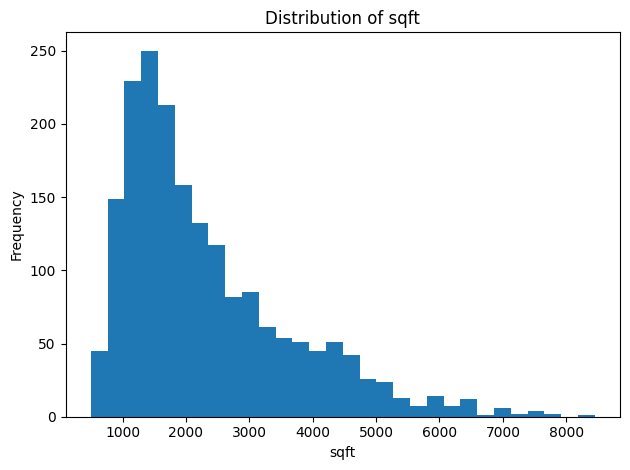

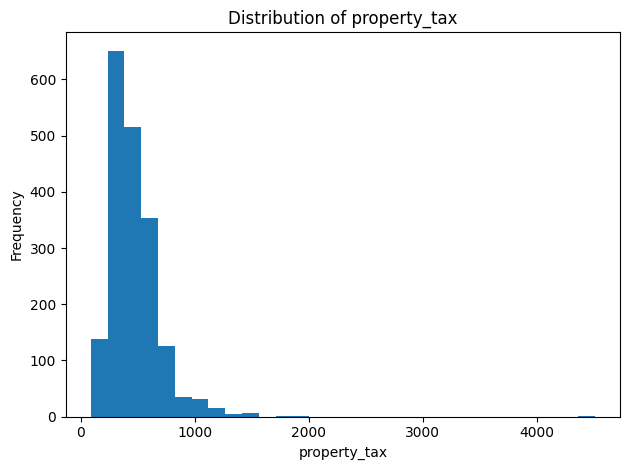

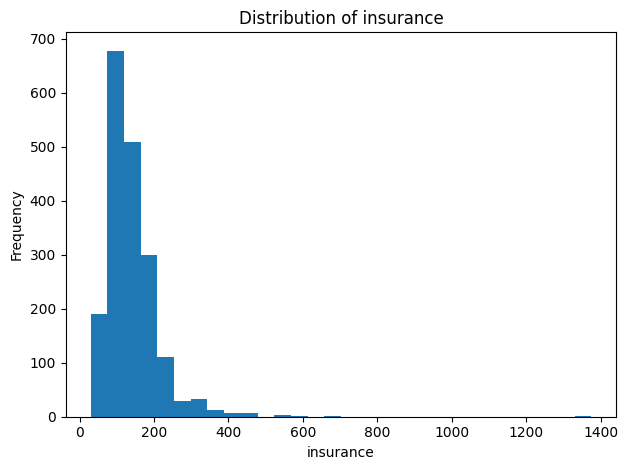

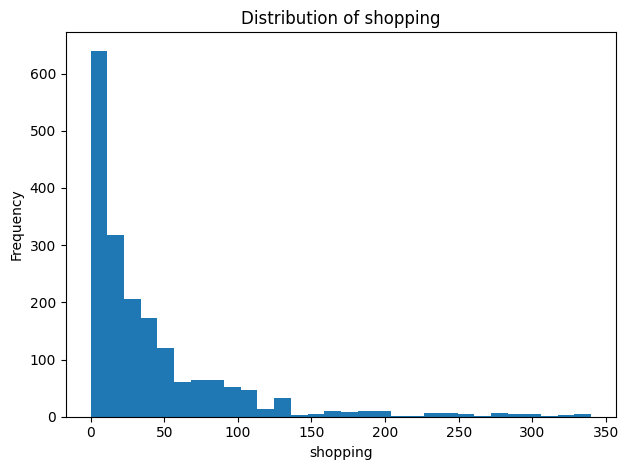

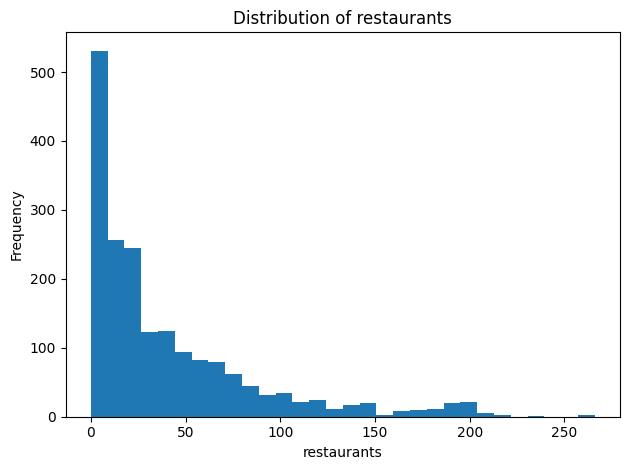

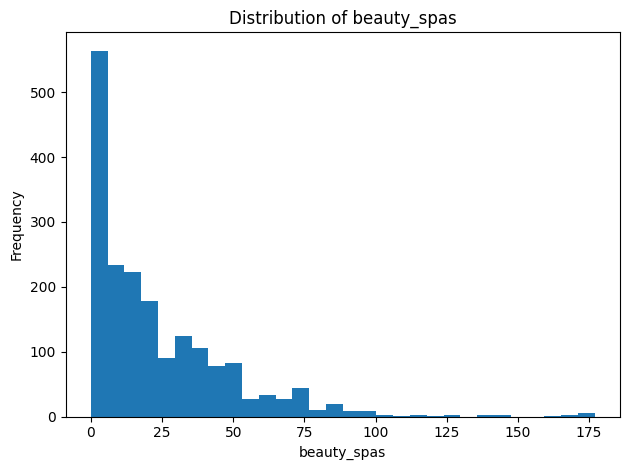

['tx_price',
 'lot_size',
 'sqft',
 'property_tax',
 'insurance',
 'shopping',
 'restaurants',
 'beauty_spas']

In [11]:

# --- Distributions: Top-Variance Numeric Columns ---
numeric_variances = []
for c in numeric_cols:
    try:
        numeric_variances.append((c, float(np.nanvar(df[c].astype(float)))))
    except Exception:
        pass

numeric_variances = sorted(numeric_variances, key=lambda x: x[1], reverse=True)
top_numeric_for_hist = [c for c, _ in numeric_variances[:8]]

for c in top_numeric_for_hist:
    plt.figure()
    df[c].dropna().plot(kind="hist", bins=30)
    plt.title(f"Distribution of {c}")
    plt.xlabel(c); plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

top_numeric_for_hist


,tx_price,beds,baths,sqft,lot_size,basement,restaurants,groceries,nightlife,cafes,shopping,arts_entertainment,beauty_spas,active_life,median_age,married,college_grad,property_tax,insurance,median_school,num_schools
tx_price,1.000000,0.384046,0.389375,0.469573,0.130558,NaN,-0.038027,-0.094314,0.009361,-0.001398,-0.038246,-0.021076,-0.054349,-0.001165,0.126335,0.200494,0.268577,0.535148,0.532947,0.175762,-0.014380
beds,0.384046,1.000000,0.644572,0.691039,0.164399,NaN,-0.495834,-0.421412,-0.440844,-0.464289,-0.388670,-0.442168,-0.419832,-0.486957,0.133711,0.643240,-0.082354,0.547643,0.485776,0.137309,-0.124359
baths,0.389375,0.644572,1.000000,0.682060,0.132976,NaN,-0.350210,-0.340024,-0.306686,-0.316836,-0.259603,-0.305885,-0.282008,-0.329736,0.095844,0.442225,0.016097,0.525776,0.475430,0.163365,-0.088299
sqft,0.469573,0.691039,0.682060,1.000000,0.246016,NaN,-0.353759,-0.371167,-0.281540,-0.300969,-0.275586,-0.293402,-0.310465,-0.332663,0.109811,0.480167,0.065343,0.660264,0.594049,0.220669,-0.102032
lot_size,0.130558,0.164399,0.132976,0.246016,1.000000,NaN,-0.113887,-0.118574,-0.072224,-0.098182,-0.116560,-0.067189,-0.121075,-0.092668,0.099140,0.122028,-0.030725,0.165800,0.146579,0.096551,-0.031535
basement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
restaurants,-0.038027,-0.495834,-0.350210,-0.353759,-0.113887,NaN,1.000000,0.701462,0.926675,0.937616,0.818815,0.726907,0.867829,0.881799,-0.063816,-0.615584,0.214260,-0.100821,-0.019925,-0.068425,0.251171
groceries,-0.094314,-0.421412,-0.340024,-0.371167,-0.118574,NaN,0.701462,1.000000,0.565003,0.602857,0.526356,0.502837,0.626850,0.574532,-0.022377,-0.508793,-0.006025,-0.159506,-0.093974,-0.354553,0.272856
nightlife,0.009361,-0.440844,-0.306686,-0.281540,-0.072224,NaN,0.926675,0.565003,1.000000,0.923901,0.743321,0.703038,0.777461,0.858836,-0.028611,-0.568811,0.253717,-0.054386,0.024551,-0.036948,0.196399
cafes,-0.001398,-0.464289,-0.316836,-0.300969,-0.098182,NaN,0.937616,0.602857,0.923901,1.000000,0.837058,0.694575,0.822541,0.826648,0.026400,-0.581850,0.266652,-0.044410,0.036502,-0.027868,0.224312


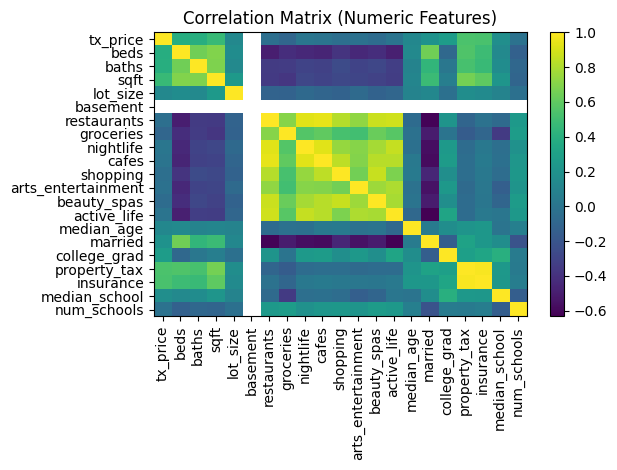

In [12]:

# --- Correlation Matrix (numeric) ---
if len(numeric_cols) >= 2:
    corr = df[numeric_cols].corr(numeric_only=True)
    display(corr)

    plt.figure()
    plt.imshow(corr, aspect="auto")
    plt.colorbar()
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.index)), corr.index)
    plt.title("Correlation Matrix (Numeric Features)")
    plt.tight_layout()
    plt.show()
else:
    print("Not enough numeric columns to compute correlation.")


In [13]:

# --- Target Guessing ---
def guess_target(_df: pd.DataFrame, numeric_candidates: list) -> str | None:
    name_priority = ["saleprice","price","soldprice","listprice","askingprice",
                     "rent","rentalprice","value","valuation","target","label","y"]
    lower_map = {c.lower(): c for c in numeric_candidates}
    for key in name_priority:
        if key in lower_map:
            return lower_map[key]
        for lc, orig in lower_map.items():
            if key in lc:
                return orig
    return None

target_col = guess_target(df, numeric_cols)
print("Detected target column:", target_col)


Detected target column: tx_price


In [14]:

# --- Categorical Impact on Target (if regression target) ---
def cat_impact_tables(df: pd.DataFrame, target: str, categorical_cols: list, topn: int = 10):
    results = {}
    for c in categorical_cols:
        if df[c].nunique(dropna=True) > 100:
            continue
        tmp = df[[c, target]].copy()
        tmp = tmp.dropna(subset=[target])
        if tmp.empty:
            continue
        g = tmp.groupby(c, dropna=False)[target].agg(["count","mean"]).sort_values("count", ascending=False)
        results[c] = g.head(topn).rename(columns={"mean": f"Mean_{target}"})
    return results

if target_col and (target_col in df.columns) and (target_col in numeric_cols):
    cat_imp = cat_impact_tables(df, target_col, categorical_cols, topn=10)
    shown = 0
    for k, v in cat_imp.items():
        print(f"\nCategory Impact on {target_col} ::", k)
        display(v)
        shown += 1
        if shown >= 5:
            break
else:
    print("No numeric target detected for category impact.")



Category Impact on tx_price :: property_type


,count,Mean_tx_price
property_type,,
Single-Family,1080,464644.711111
Apartment / Condo / Townhouse,803,366614.034869



Category Impact on tx_price :: exterior_walls


,count,Mean_tx_price
exterior_walls,,
Brick,687,417601.874818
Siding (Alum/Vinyl),503,409409.298211
NaN,223,413780.417040
Metal,120,443991.108333
Combination,107,438498.140187
Wood,72,415984.500000
Wood Siding,49,471862.734694
Brick veneer,48,573275.208333
Stucco,26,402177.000000



Category Impact on tx_price :: roof


,count,Mean_tx_price
roof,,
Composition Shingle,1179,430104.691264
NaN,354,386396.570621
Asphalt,132,428134.621212
Shake Shingle,55,446063.672727
Other,49,441730.428571
Gravel/Rock,30,313834.633333
Wood Shake/ Shingles,30,531686.966667
Roll Composition,12,333230.583333
Asbestos,9,522114.333333


,Model,Metric1,Metric2
0,LinearRegression,RMSE=122836.23,R2=0.378
1,RandomForestRegressor,RMSE=113737.25,R2=0.466


,Feature,Importance
17,insurance,0.399280
16,property_tax,0.157036
3,lot_size,0.050009
2,sqft,0.048572
14,married,0.035638
13,median_age,0.034858
15,college_grad,0.034506
9,shopping,0.030887
11,beauty_spas,0.028136
12,active_life,0.024279


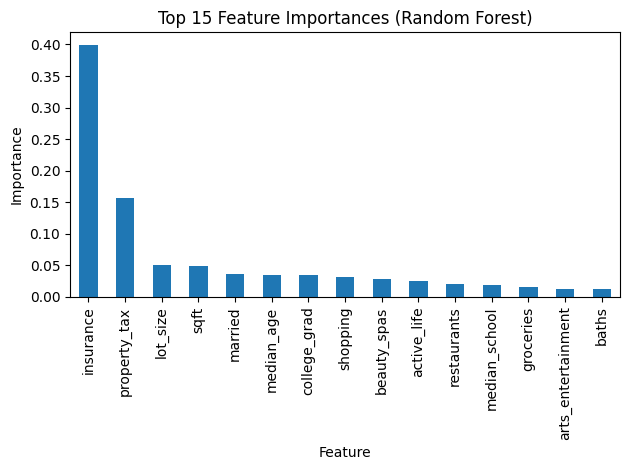

In [15]:

# --- Quick Modeling & Feature Importance ---
feat_importances_df = None
model_summary_rows = []

if target_col and (target_col in df.columns):
    y = df[target_col]
    # Determine task type
    task_type = "regression"
    if not pd.api.types.is_numeric_dtype(y):
        task_type = "classification"
    else:
        if y.nunique(dropna=True) <= 10 and set(y.dropna().unique()).issubset({0,1}):
            task_type = "classification"

    # Build X (numeric + limited one-hot cats)
    X_num = df[[c for c in numeric_cols if c != target_col]].copy()
    X_cat = pd.DataFrame(index=df.index)
    for c in categorical_cols:
        if df[c].nunique(dropna=True) <= 30:
            X_cat = pd.concat([X_cat, pd.get_dummies(df[c], prefix=c, dummy_na=True)], axis=1)
    X = pd.concat([X_num, X_cat], axis=1)
    valid = ~y.isna(); X = X.loc[valid]; y = y.loc[valid]
    X = X.fillna(X.median(numeric_only=True)).fillna(0)
    for c in X.columns:
        if not pd.api.types.is_numeric_dtype(X[c]):
            X[c] = pd.to_numeric(X[c], errors="coerce").fillna(0)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if task_type == "regression":
        lr = LinearRegression()
        lr.fit(X_train, y_train)
        y_pred_lr = lr.predict(X_test)
        rmse_lr = math.sqrt(mean_squared_error(y_test, y_pred_lr))
        r2_lr = r2_score(y_test, y_pred_lr)
        model_summary_rows.append(["LinearRegression", f"RMSE={rmse_lr:.2f}", f"R2={r2_lr:.3f}"])

        rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred_rf = rf.predict(X_test)
        rmse_rf = math.sqrt(mean_squared_error(y_test, y_pred_rf))
        r2_rf = r2_score(y_test, y_pred_rf)
        model_summary_rows.append(["RandomForestRegressor", f"RMSE={rmse_rf:.2f}", f"R2={r2_rf:.3f}"])

        feat_importances_df = pd.DataFrame({
            "Feature": X.columns,
            "Importance": rf.feature_importances_
        }).sort_values("Importance", ascending=False)

    else:
        if not pd.api.types.is_numeric_dtype(y):
            y = pd.factorize(y)[0]

        logreg = LogisticRegression(max_iter=1000)
        logreg.fit(X_train, y_train)
        y_pred_lr = logreg.predict(X_test)
        acc_lr = accuracy_score(y_test, y_pred_lr)
        f1_lr = f1_score(y_test, y_pred_lr, average="weighted")
        model_summary_rows.append(["LogisticRegression", f"ACC={acc_lr:.3f}", f"F1={f1_lr:.3f}"])

        rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred_rf = rf.predict(X_test)
        acc_rf = accuracy_score(y_test, y_pred_rf)
        f1_rf = f1_score(y_test, y_pred_rf, average="weighted")
        model_summary_rows.append(["RandomForestClassifier", f"ACC={acc_rf:.3f}", f"F1={f1_rf:.3f}"])

        feat_importances_df = pd.DataFrame({
            "Feature": X.columns,
            "Importance": rf.feature_importances_
        }).sort_values("Importance", ascending=False)

    display(pd.DataFrame(model_summary_rows, columns=["Model","Metric1","Metric2"]))

    if feat_importances_df is not None and not feat_importances_df.empty:
        display(feat_importances_df.head(20))
        plt.figure()
        feat_importances_df.head(15).set_index("Feature")["Importance"].plot(kind="bar")
        plt.title("Top 15 Feature Importances (Random Forest)")
        plt.ylabel("Importance")
        plt.tight_layout()
        plt.show()
else:
    print("No target column detected; skipping quick modeling.")


,Month,Volume,MedianTarget
0,1880-01-01,1,248000.0
1,1892-01-01,1,650000.0
2,1900-01-01,3,640000.0
3,1905-01-01,1,700000.0
4,1918-01-01,1,234000.0
5,1920-01-01,4,552500.0
6,1921-01-01,1,370000.0
7,1924-01-01,1,499000.0
8,1925-01-01,3,566700.0
9,1927-01-01,1,675000.0


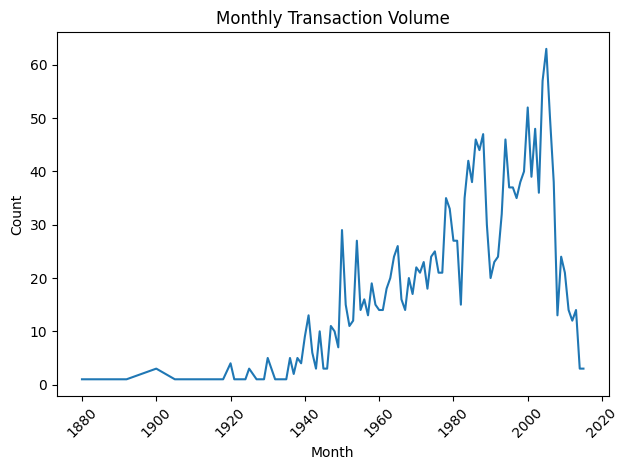

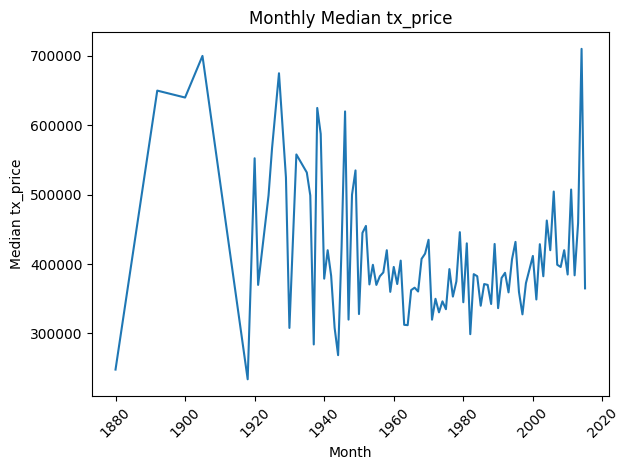

In [16]:

# --- Time Series Trends (if datetime and target exist) ---
def find_main_datetime_col(cols):
    priority = ["date","saledate","listdate","posteddate","transactiondate"]
    lower_map = {c.lower(): c for c in cols}
    for key in priority:
        for lc, orig in lower_map.items():
            if key in lc:
                return orig
    return cols[0] if cols else None

main_dt = find_main_datetime_col(datetime_cols)

if (main_dt is not None) and (target_col is not None) and (target_col in df.columns):
    tmp = df[[main_dt, target_col]].copy().dropna(subset=[main_dt])
    if not pd.api.types.is_datetime64_any_dtype(tmp[main_dt]):
        tmp[main_dt] = pd.to_datetime(tmp[main_dt], errors="coerce")
    tmp = tmp.dropna(subset=[main_dt])
    if not tmp.empty:
        tmp["Month"] = tmp[main_dt].dt.to_period("M").dt.to_timestamp()
        monthly = tmp.groupby("Month").agg(
            Volume=(target_col, "count"),
            MedianTarget=(target_col, "median")
        ).reset_index()
        display(monthly.head(36))

        plt.figure()
        plt.plot(monthly["Month"], monthly["Volume"])
        plt.title("Monthly Transaction Volume")
        plt.xlabel("Month"); plt.ylabel("Count")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        plt.figure()
        plt.plot(monthly["Month"], monthly["MedianTarget"])
        plt.title(f"Monthly Median {target_col}")
        plt.xlabel("Month"); plt.ylabel(f"Median {target_col}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
else:
    print("No suitable datetime/target combination found for time trends.")


In [17]:

# --- Insights & Optional Stakeholder HTML Report ---
insights = []

# Missingness
if 'missing_df' in globals() and not missing_df.empty:
    high_missing = missing_df[missing_df["Missing_%"] >= 20.0]["Column"].tolist()
    if high_missing:
        insights.append(f"{len(high_missing)} fields have ≥20% missing values (e.g., {', '.join(high_missing[:5])}{'...' if len(high_missing) > 5 else ''}). Prioritize imputation or mandatory capture.")

# Outliers
if 'outlier_rates' in globals() and not outlier_rates.empty:
    heavy_outliers = outlier_rates[outlier_rates["Outlier_%"] >= 5.0]["Column"].tolist()
    if heavy_outliers:
        insights.append(f"{len(heavy_outliers)} numeric features show ≥5% outliers. Consider trimming/winsorization or robust scalers. Notable: {', '.join(heavy_outliers[:5])}{'...' if len(heavy_outliers) > 5 else ''}.")

# Correlations
if len(numeric_cols) >= 2:
    corr_vals = df[numeric_cols].corr(numeric_only=True).abs()
    pairs = []
    cols = corr_vals.columns
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            pairs.append((cols[i], cols[j], float(corr_vals.iloc[i, j])))
    pairs = sorted(pairs, key=lambda x: x[2], reverse=True)[:3]
    if pairs:
        insights.append("Top numeric correlations: " + "; ".join([f"{a}–{b}: {v:.2f}" for a,b,v in pairs]) + ".")

# Feature drivers
try:
    if 'feat_importances_df' in globals() and feat_importances_df is not None and not feat_importances_df.empty and target_col:
        top_feats = feat_importances_df.head(5)["Feature"].tolist()
        insights.append(f"Key drivers of {target_col}: {', '.join(top_feats)}.")
except Exception:
    pass

# Time momentum
try:
    if 'main_dt' in globals() and main_dt and target_col and target_col in df.columns:
        tmp = df[[main_dt, target_col]].copy()
        tmp = tmp.dropna(subset=[main_dt])
        if not pd.api.types.is_datetime64_any_dtype(tmp[main_dt]):
            tmp[main_dt] = pd.to_datetime(tmp[main_dt], errors="coerce")
        tmp = tmp.dropna(subset=[main_dt])
        tmp["Month"] = tmp[main_dt].dt.to_period("M").dt.to_timestamp()
        monthly = tmp.groupby("Month").agg(Volume=(target_col,"count"), MedianTarget=(target_col,"median")).reset_index()
        if not monthly.empty and len(monthly) >= 6:
            recent = monthly.tail(3)["MedianTarget"].median()
            prev = monthly.tail(6).head(3)["MedianTarget"].median()
            if not (pd.isna(recent) or pd.isna(prev)):
                pct = ((recent - prev) / (prev + 1e-9)) * 100.0
                direction = "up" if pct > 0 else "down"
                insights.append(f"Median {target_col} is {direction} ~{abs(pct):.1f}% over the last 3 months vs prior 3.")
except Exception:
    pass

print("Insights:")
for i, ins in enumerate(insights, 1):
    print(f"{i}. {ins}")


Insights:
1. 6 numeric features show ≥5% outliers. Consider trimming/winsorization or robust scalers. Notable: cafes, nightlife, lot_size, shopping, restaurants....
2. Top numeric correlations: tx_price–basement: nan; beds–sqft: 0.69; beds–basement: nan.
3. Key drivers of tx_price: insurance, property_tax, lot_size, sqft, married.
4. Median tx_price is up ~19.3% over the last 3 months vs prior 3.


In [19]:
# --- Stakeholder HTML Report (single-file with embedded charts) ---
# Paste this cell into your notebook and run it.
import io, base64, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score


def _fig_to_base64():
    buf = io.BytesIO()
    plt.savefig(buf, format="png", bbox_inches="tight")
    buf.seek(0)
    b64 = base64.b64encode(buf.read()).decode("utf-8")
    plt.close()
    return b64


def _is_categorical(s, thresh=30):
    if s.dtype == "O":
        return True
    uniq = s.nunique(dropna=True)
    return uniq <= min(thresh, max(2, int(0.05 * len(s))))


def _try_parse_dates(_df):
    out = _df.copy()
    for c in out.columns:
        lc = str(c).lower()
        if ("date" in lc) or ("time" in lc):
            out[c] = pd.to_datetime(out[c], errors="ignore")
    return out


def _guess_target(_df, numeric_candidates):
    keys = [
        "saleprice",
        "price",
        "soldprice",
        "listprice",
        "askingprice",
        "rent",
        "rentalprice",
        "value",
        "valuation",
        "target",
        "label",
        "y",
    ]
    lm = {c.lower(): c for c in numeric_candidates}
    for k in keys:
        if k in lm:
            return lm[k]
        for lc, orig in lm.items():
            if k in lc:
                return orig
    return None


def _find_main_datetime_col(cols):
    priority = [
        "date",
        "saledate",
        "listdate",
        "posteddate",
        "transactiondate",
        "tx_date",
        "txdate",
    ]
    lm = {c.lower(): c for c in cols}
    for key in priority:
        for lc, orig in lm.items():
            if key in lc:
                return orig
    return cols[0] if cols else None


def _find_geo_cols(columns):
    lat_keys = ["latitude", "lat", "y"]
    lon_keys = ["longitude", "lon", "lng", "long", "x"]
    lm = {c.lower(): c for c in columns}
    lat = next(
        (orig for lc, orig in lm.items() if any(k in lc for k in lat_keys)), None
    )
    lon = next(
        (orig for lc, orig in lm.items() if any(k in lc for k in lon_keys)), None
    )
    return lat, lon


def _iqr_outlier_rate(s):
    s = s.dropna()
    if s.empty:
        return 0.0
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    if iqr == 0:
        return 0.0
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return float((((s < lower) | (s > upper)).mean() * 100).round(2))


def generate_stakeholder_report(
    df, output_path="real_estate_eda_stakeholder_report.html", sample_geo_n=5000
):
    # --- Type inference and preparation ---
    df = _try_parse_dates(df)

    # Optional: convert common year-only columns to datetime (YYYY-01-01)
    for col in ["year_built", "tx_year", "transaction_year"]:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col].astype(str), format="%Y", errors="coerce")

    numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    datetime_cols = [
        c for c in df.columns if pd.api.types.is_datetime64_any_dtype(df[c])
    ]
    categorical_cols = [
        c
        for c in df.columns
        if (c not in numeric_cols + datetime_cols) and _is_categorical(df[c])
    ]

    # Missingness
    missing_df = (
        (df.isna().mean() * 100).round(2).sort_values(ascending=False).reset_index()
    )
    missing_df.columns = ["Column", "Missing_%"]
    top_missing = missing_df.set_index("Column")["Missing_%"].head(20)

    # Outliers
    outlier_rates = pd.DataFrame(
        {
            "Column": numeric_cols,
            "Outlier_%": [_iqr_outlier_rate(df[c]) for c in numeric_cols],
        }
    ).sort_values("Outlier_%", ascending=False)

    # Correlation
    corr = df[numeric_cols].corr(numeric_only=True) if len(numeric_cols) >= 2 else None

    # Guess target and build quick model + feature importance
    target_col = _guess_target(df, numeric_cols)
    feat_importances_df = None
    model_summary_rows = []
    if target_col and target_col in df.columns:
        y = df[target_col]
        task_type = "regression"
        if not pd.api.types.is_numeric_dtype(y):
            task_type = "classification"
        else:
            if y.nunique(dropna=True) <= 10 and set(
                pd.Series(y.dropna().unique()).astype(float)
            ).issubset({0.0, 1.0}):
                task_type = "classification"

        # X = numeric + limited one-hot cats
        X_num = df[[c for c in numeric_cols if c != target_col]].copy()
        X_cat = pd.DataFrame(index=df.index)
        for c in categorical_cols:
            if df[c].nunique(dropna=True) <= 30:
                X_cat = pd.concat(
                    [X_cat, pd.get_dummies(df[c], prefix=c, dummy_na=True)], axis=1
                )
        X = pd.concat([X_num, X_cat], axis=1)

        valid = ~y.isna()
        X, y = X.loc[valid], y.loc[valid]
        X = X.fillna(X.median(numeric_only=True)).fillna(0)
        for c in X.columns:
            if not pd.api.types.is_numeric_dtype(X[c]):
                X[c] = pd.to_numeric(X[c], errors="coerce").fillna(0)

        if len(X) >= 10:
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42
            )

            if task_type == "regression":
                lr = LinearRegression().fit(X_train, y_train)
                ypl = lr.predict(X_test)
                model_summary_rows.append(
                    [
                        "LinearRegression",
                        f"RMSE={math.sqrt(mean_squared_error(y_test, ypl)):.2f}",
                        f"R2={r2_score(y_test, ypl):.3f}",
                    ]
                )

                rf = RandomForestRegressor(
                    n_estimators=300, random_state=42, n_jobs=-1
                ).fit(X_train, y_train)
                ypr = rf.predict(X_test)
                model_summary_rows.append(
                    [
                        "RandomForestRegressor",
                        f"RMSE={math.sqrt(mean_squared_error(y_test, ypr)):.2f}",
                        f"R2={r2_score(y_test, ypr):.3f}",
                    ]
                )

                feat_importances_df = pd.DataFrame(
                    {"Feature": X.columns, "Importance": rf.feature_importances_}
                ).sort_values("Importance", ascending=False)

            else:
                if not pd.api.types.is_numeric_dtype(y):
                    y = pd.factorize(y)[0]

                lg = LogisticRegression(max_iter=1000).fit(X_train, y_train)
                ypl = lg.predict(X_test)
                model_summary_rows.append(
                    [
                        "LogisticRegression",
                        f"ACC={accuracy_score(y_test, ypl):.3f}",
                        f"F1={f1_score(y_test, ypl, average='weighted'):.3f}",
                    ]
                )

                rf = RandomForestClassifier(
                    n_estimators=300, random_state=42, n_jobs=-1
                ).fit(X_train, y_train)
                ypr = rf.predict(X_test)
                model_summary_rows.append(
                    [
                        "RandomForestClassifier",
                        f"ACC={accuracy_score(y_test, ypr):.3f}",
                        f"F1={f1_score(y_test, ypr, average='weighted'):.3f}",
                    ]
                )

                # FIXED LINE: removed stray quote after rf.feature_importances_
                feat_importances_df = pd.DataFrame(
                    {"Feature": X.columns, "Importance": rf.feature_importances_}
                ).sort_values("Importance", ascending=False)

    # Time series
    main_dt = _find_main_datetime_col(datetime_cols) if datetime_cols else None
    monthly = None
    if main_dt and target_col and target_col in df.columns:
        tmp = df[[main_dt, target_col]].copy().dropna(subset=[main_dt])
        if not pd.api.types.is_datetime64_any_dtype(tmp[main_dt]):
            tmp[main_dt] = pd.to_datetime(tmp[main_dt], errors="coerce")
        tmp = tmp.dropna(subset=[main_dt])
        if not tmp.empty:
            tmp["Month"] = tmp[main_dt].dt.to_period("M").dt.to_timestamp()
            monthly = (
                tmp.groupby("Month")
                .agg(Volume=(target_col, "count"), MedianTarget=(target_col, "median"))
                .reset_index()
            )

    # Geo chart skipped: no latitude/longitude columns in dataset
    geo_img = None

    # --- Recreate key charts as base64 ---
    images = {}

    # Missingness chart
    if not top_missing.empty:
        plt.figure()
        top_missing.plot(kind="bar")
        plt.title("Top 20 Columns by Missingness (%)")
        plt.ylabel("Missing %")
        plt.tight_layout()
        images["missingness"] = _fig_to_base64()

    # Outliers chart
    if not outlier_rates.empty:
        plt.figure()
        outlier_rates.head(15).set_index("Column")["Outlier_%"].plot(kind="bar")
        plt.title("Top 15 Outlier-Prone Numeric Columns (IQR %)")
        plt.ylabel("Outlier %")
        plt.tight_layout()
        images["outliers"] = _fig_to_base64()

    # Correlation heatmap
    if corr is not None:
        plt.figure()
        plt.imshow(corr, aspect="auto")
        plt.colorbar()
        plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
        plt.yticks(range(len(corr.index)), corr.index)
        plt.title("Correlation Matrix (Numeric Features)")
        plt.tight_layout()
        images["correlation"] = _fig_to_base64()

    # Feature importances
    if feat_importances_df is not None and not feat_importances_df.empty:
        plt.figure()
        feat_importances_df.head(15).set_index("Feature")["Importance"].plot(kind="bar")
        plt.title("Top 15 Feature Importances (Random Forest)")
        plt.ylabel("Importance")
        plt.tight_layout()
        images["feat_importance"] = _fig_to_base64()

    # Time series charts
    if monthly is not None and not monthly.empty:
        plt.figure()
        plt.plot(monthly["Month"], monthly["Volume"])
        plt.title("Monthly Transaction Volume")
        plt.xlabel("Month")
        plt.ylabel("Count")
        plt.xticks(rotation=45)
        plt.tight_layout()
        images["volume"] = _fig_to_base64()

        plt.figure()
        plt.plot(monthly["Month"], monthly["MedianTarget"])
        plt.title(f"Monthly Median {target_col}")
        plt.xlabel("Month")
        plt.ylabel(f"Median {target_col}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        images["median_target"] = _fig_to_base64()

    # --- Insights ---
    insights = []
    # Missingness
    high_miss = missing_df[missing_df["Missing_%"] >= 20.0]["Column"].tolist()
    if high_miss:
        insights.append(
            f"{len(high_miss)} fields have ≥20% missing values (e.g., {', '.join(high_miss[:5])}{'...' if len(high_miss) > 5 else ''}). Prioritize imputation or mandatory capture."
        )
    # Outliers
    heavy = outlier_rates[outlier_rates["Outlier_%"] >= 5.0]["Column"].tolist()
    if heavy:
        insights.append(
            f"{len(heavy)} numeric features show ≥5% outliers. Consider trimming/winsorization or robust scalers. Notable: {', '.join(heavy[:5])}{'...' if len(heavy) > 5 else ''}."
        )
    # Correlations
    if corr is not None:
        ac = corr.abs()
        pairs = []
        cols = ac.columns
        for i in range(len(cols)):
            for j in range(i + 1, len(cols)):
                pairs.append((cols[i], cols[j], float(ac.iloc[i, j])))
        pairs = sorted(pairs, key=lambda x: x[2], reverse=True)[:3]
        if pairs:
            insights.append(
                "Top numeric correlations: "
                + "; ".join([f"{a}–{b}: {v:.2f}" for a, b, v in pairs])
                + "."
            )
    # Feature drivers
    if feat_importances_df is not None and not feat_importances_df.empty and target_col:
        insights.append(
            "Key drivers of {}: {}.".format(
                target_col, ", ".join(feat_importances_df.head(5)["Feature"].tolist())
            )
        )
    # Time momentum
    if monthly is not None and len(monthly) >= 6 and target_col:
        recent = monthly.tail(3)["MedianTarget"].median()
        prev = monthly.tail(6).head(3)["MedianTarget"].median()
        if not (pd.isna(recent) or pd.isna(prev)):
            pct = ((recent - prev) / (prev + 1e-9)) * 100.0
            direction = "up" if pct > 0 else "down"
            insights.append(
                f"Median {target_col} is {direction} ~{abs(pct):.1f}% over the last 3 months vs prior 3."
            )

    # --- Build HTML ---
    html = []
    html.append("""
<!DOCTYPE html>
<html lang="en">
<head>
<meta charset="UTF-8">
<title>Real Estate EDA – Stakeholder Report</title>
<style>
body { font-family: Arial, sans-serif; margin: 24px; line-height: 1.5; }
h1, h2, h3 { margin-top: 24px; }
.section { margin-bottom: 28px; }
.kpi { display: inline-block; padding: 12px 16px; margin: 8px 8px 8px 0; border: 1px solid #ddd; border-radius: 8px; }
img { max-width: 100%; height: auto; border: 1px solid #eee; padding: 6px; border-radius: 6px; }
.caption { font-size: 0.9em; color: #444; margin-top: 4px; }
.callout { background: #f7f7f7; border-left: 4px solid #999; padding: 12px; margin: 12px 0; }
</style>
</head>
<body>
<h1>Real Estate EDA – Stakeholder Report</h1>
<p>This report summarizes patterns discovered in the dataset and provides data-driven recommendations to drive business impact.</p>
""")

    html.append(f"""
<div class="section">
  <h2>Snapshot</h2>
  <div class="kpi"><strong>Rows</strong><br>{len(df):,}</div>
  <div class="kpi"><strong>Columns</strong><br>{len(df.columns)}</div>
  <div class="kpi"><strong>Duplicates</strong><br>{int(df.duplicated().sum())}</div>
  <div class="kpi"><strong>Target</strong><br>{target_col if target_col else "Not detected"}</div>
  <div class="kpi"><strong>Date Field</strong><br>{main_dt if main_dt else "Not detected"}</div>
</div>
""")

    def _tag(key, caption):
        return (
            f'<div class="section"><img src="data:image/png;base64,{images[key]}"/><div class="caption">{caption}</div></div>'
            if key in images
            else ""
        )

    html.append('<div class="section"><h2>Key Visuals</h2>')
    html.append(
        _tag("missingness", "Top missing fields – prioritize data quality fixes.")
    )
    html.append(_tag("outliers", "Outlier-prone features – consider robust treatment."))
    html.append(_tag("correlation", "Correlation map – monitor multicollinearity."))
    html.append(_tag("feat_importance", "Top feature drivers from Random Forest."))
    html.append(_tag("volume", "Transaction volume by month."))
    html.append(_tag("median_target", f"Median {target_col or 'target'} by month."))
    # Geo chart skipped
    html.append("</div>")

    html.append('<div class="section"><h2>Insights That Matter</h2><ul>')
    for ins in insights:
        html.append(f"<li>{ins}</li>")
    html.append("</ul></div>")

    # Actions
    recs = []
    if target_col:
        recs.append(
            f"Use {target_col} drivers (top features) to refine pricing models and agent playbooks."
        )
    if monthly is not None and not monthly.empty:
        recs.append(
            "Time promotions with months showing rising prices and higher volume."
        )
    if corr is not None:
        recs.append(
            "Monitor multicollinearity in linear models; prefer trees or regularization if needed."
        )
    if (missing_df["Missing_%"] > 0).any():
        recs.append(
            "Fix high-missing fields at collection; add validation and mandatory capture for critical attributes."
        )
    if not recs:
        recs.append(
            "Standardize data collection and monitor leading indicators across time and location."
        )

    html.append('<div class="section"><h2>Recommended Actions</h2><ol>')
    for r in recs:
        html.append(f"<li>{r}</li>")
    html.append("</ol></div>")

    html.append("""
<div class="section">
  <h2>Notes</h2>
  <div class="callout">
    The analysis is exploratory. Validate with out-of-sample data and perform stability tests across time and sub-markets before production use.
  </div>
</div>
</body></html>
""")

    with open(output_path, "w", encoding="utf-8") as f:
        f.write("".join(html))

    print(f"Stakeholder report written to: {output_path}")


# --- Run it (change path if you want a different filename) ---

# Example: Load your data into a DataFrame named df before running the report.
# Replace the file path with your actual data file.
df = pd.read_csv("../data/real_estate_data.csv")

generate_stakeholder_report(df, output_path="real_estate_eda_stakeholder_report.html")


Stakeholder report written to: real_estate_eda_stakeholder_report.html
